#Computer Graphics Assignment #5: Supplementary
This supplementary notebook is created by Chinchuthakun Worameth as a part of Computer Graphics (ART.T463) at Tokyo Institute of Technology taught in Fall semester 2021 by Prof. Saito Suguru. It contains all numerical calculations for the assignment #5.

## 0. Data Preparation

**Before execute this notebook, please manually upload *pigments.zip* and *XYZ_CIE_2.dat***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path

### 0.1 Reading CIEXYZ1931 Matching Functions

In [ ]:
ciexyz = pd.read_csv('XYZ_CIE_2.dat', header=None, sep='\t', engine='python')
ciexyz.columns = ["wavelength", "X", "Y", "Z"]
ciexyz.head(5)

,wavelength,X,Y,Z
0,380,0.001368,0.000039,0.006450
1,381,0.001502,0.000043,0.007083
2,382,0.001642,0.000047,0.007745
3,383,0.001802,0.000052,0.008501
4,384,0.001996,0.000057,0.009415


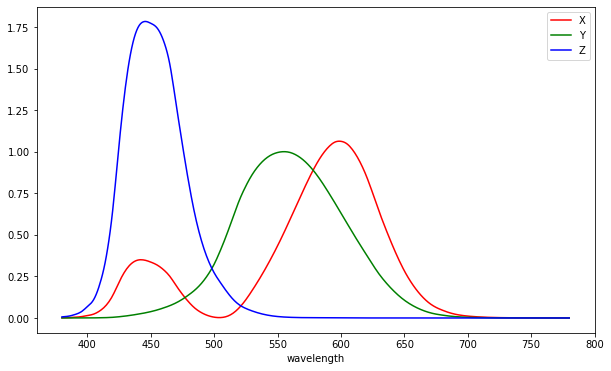

In [ ]:
ciexyz.plot(kind="line", x="wavelength", y=["X", "Y", "Z"], color={"X": "red", "Y": "green", "Z": "blue"}, figsize = (10,6))

### 0.2 Reading Pigment Reflectances

In [ ]:
! unzip pigments.zip

Archive:  pigments.zip
   creating: Pigmentdata/
  inflating: Pigmentdata/74plot      
  inflating: Pigmentdata/72plot      
  inflating: Pigmentdata/46plot      
  inflating: Pigmentdata/58plot      
  inflating: Pigmentdata/15plot      
  inflating: Pigmentdata/33plot      
  inflating: Pigmentdata/6plot       
  inflating: Pigmentdata/64plot      
  inflating: Pigmentdata/1plot       
  inflating: Pigmentdata/41plot      
  inflating: Pigmentdata/92plot      
  inflating: Pigmentdata/84plot      
  inflating: Pigmentdata/51plot      


In [ ]:
dir = 'Pigmentdata'
pigments = Path(dir ).glob('*')
pigments_df = []
for i in pigments:
    df = pd.read_csv(i, header=None, sep='\t', engine='python', skiprows=2)
    df.columns = ["wavelength", i.stem]
    pigments_df.append(df)

In [ ]:
reflectances = pigments_df[0]
for i in range(1,len(pigments_df)):
  reflectances = reflectances.merge(pigments_df[i], on = "wavelength")
reflectances.head(5)

,wavelength,51plot,58plot,15plot,6plot,64plot,41plot,1plot,92plot,74plot,84plot,33plot,46plot,72plot
0,400.000000,0.509091,0.522727,0.123853,0.036364,0.706422,0.668161,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.096330
1,401.171875,0.509091,0.522727,0.123853,0.036364,0.706422,0.668161,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.091743
2,402.343750,0.509091,0.522727,0.123853,0.036364,0.711009,0.672646,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.091743
3,403.515625,0.509091,0.527273,0.123853,0.036364,0.711009,0.672646,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.091743
4,404.687500,0.509091,0.527273,0.123853,0.036364,0.711009,0.672646,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.087156


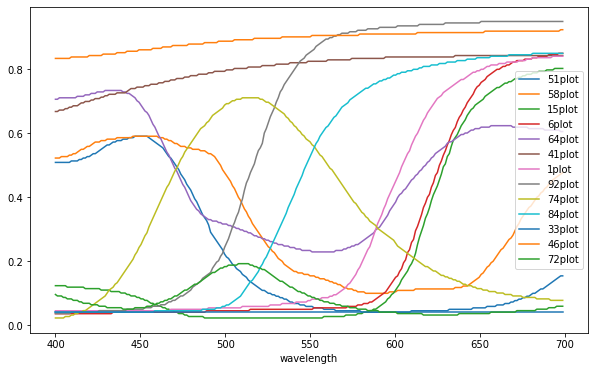

In [ ]:
reflectances.plot(kind="line", x="wavelength", figsize = (10,6))

### 0.3 Linear interpolation on reflectances

Now, we will perform linear interpolation on reflectance of each pixel at wavelengths in CIEXYZ matching functions. Following the problem description, reflectance values at less than 400nm are equal to the value at 400nm and the reflectance values at greater than 700nm are equal to the value at 700nm. 

Note that since the data point with maximum wavelength locates at less than 700nm, the value at 700nm is extrapolated.

In [ ]:
ref_wavelength = reflectances['wavelength'].to_numpy()
ref_value = reflectances.loc[:, reflectances.columns != 'wavelength'].to_numpy()
interpolated_ref = interp1d(ref_wavelength, ref_value, axis=0, bounds_error=False, fill_value="extrapolate")

In [ ]:
ciexyz_wavelength = ciexyz['wavelength'].to_numpy()
ciexyz_wavelength = np.where(ciexyz_wavelength < 400, 400, ciexyz_wavelength)
ciexyz_wavelength = np.where(ciexyz_wavelength > 700, 700, ciexyz_wavelength)
result = interpolated_ref(ciexyz_wavelength)

In [ ]:
ciexyz_wavelength = ciexyz['wavelength'].to_numpy()
int_reflectances = pd.DataFrame(np.concatenate([np.reshape(ciexyz_wavelength, (-1,1)), result], axis=1), columns=reflectances.columns.tolist())
int_reflectances.head(5)

,wavelength,51plot,58plot,15plot,6plot,64plot,41plot,1plot,92plot,74plot,84plot,33plot,46plot,72plot
0,380.0,0.509091,0.522727,0.123853,0.036364,0.706422,0.668161,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.09633
1,381.0,0.509091,0.522727,0.123853,0.036364,0.706422,0.668161,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.09633
2,382.0,0.509091,0.522727,0.123853,0.036364,0.706422,0.668161,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.09633
3,383.0,0.509091,0.522727,0.123853,0.036364,0.706422,0.668161,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.09633
4,384.0,0.509091,0.522727,0.123853,0.036364,0.706422,0.668161,0.045455,0.036697,0.022936,0.040909,0.040359,0.834081,0.09633


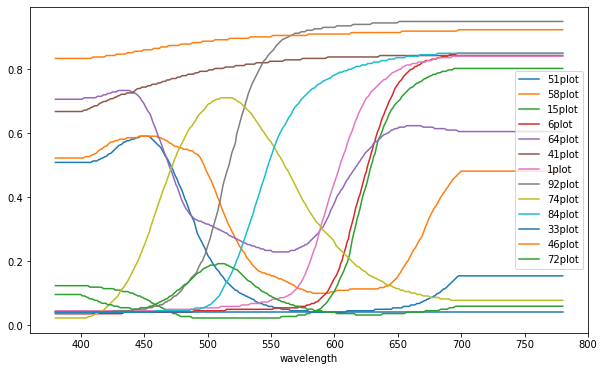

In [ ]:
int_reflectances.plot(kind="line", x="wavelength", figsize = (10,6))

## 1. CIEXYZ1931 coordinate of reflection of pigments with a D65 incident light

### 1.1 Spectrum of the D65 light

Follwing the instruction, we approximate the spectrum of the D65 light as a black-body radiation at 6504K with **Planck's equation**.

$$
L_e(\lambda) = \frac{2c^2h}{\lambda^5(e^{hc / kT\lambda} - 1)}
$$

In [ ]:
def planck(wavelength, T=6504):
  h = 6.6260755e-34 # Planck's constant
  c = 2.99792458e8 # speed of light
  k = 1.380658e-23 # Boltzmann's constant
  lamda = wavelength*1e-9
  a = 2*(c**2)*h
  b = (h*c) / (k*T*lamda)
  return a / (np.power(lamda, 5)*(np.exp(b) - 1))

   wavelength  spectral
0       380.0  1.052529
1       381.0  1.054831
2       382.0  1.057090
3       383.0  1.059306
4       384.0  1.061481


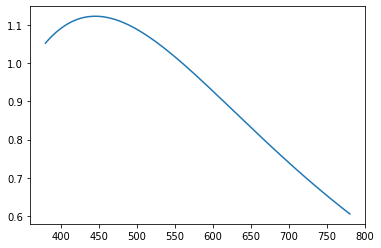

In [ ]:
wavelength = int_reflectances['wavelength'].to_numpy()
d65_relative = planck(wavelength) / planck(560)
spectral_dist = pd.DataFrame(np.concatenate([np.reshape(wavelength, (-1,1)), np.reshape(d65_relative, (-1,1))], axis=1), columns=["wavelength", "spectral"])
print(spectral_dist.head(5))
plt.plot(wavelength, d65_relative)

### 1.2 CIEXYZ1931 coordinate
Now, we calculate reflection at each $\text{Ref}(\lambda)$ by

$$
\text{Ref}(\lambda) = S(\lambda)I(\lambda)
$$

where $S(\lambda)$ and $I(\lambda)$ are reflectance of pigment and relative spectral power at wavelength $\lambda$, respectively.

Finally, by using CIEXYZ1931 matching functions, we can calculate the CIEXYZ1931 coordinate of the reflection of those pigments with a D65 incident light as

$$
X = \frac{1}{N}\int_{380}^{780} \text{Ref}(\lambda) \bar{x}(\lambda) ~d\lambda
$$

$$
Y = \frac{1}{N}\int_{380}^{780} \text{Ref}(\lambda) \bar{y}(\lambda) ~d\lambda
$$

$$
Z = \frac{1}{N}\int_{380}^{780} \text{Ref}(\lambda) \bar{z}(\lambda) ~d\lambda
$$

$$
N = \int_{380}^{780} I(\lambda) \bar{y}(\lambda) ~d\lambda
$$

where $\bar{x}(\lambda)$, $\bar{y}(\lambda)$, and $\bar{z}(\lambda)$ are the values of matching functions for $X$, $Y$, and $Z$ at wavelength $\lambda$, respectively.

In [ ]:
pigmentList = []
XYZList = []
for col in int_reflectances.columns:
  if col == "wavelength": continue
  normalize = (spectral_dist["spectral"] * ciexyz['Y']).sum()
  X_val = (spectral_dist["spectral"] * int_reflectances[col] * ciexyz['X']).sum() / normalize
  Y_val = (spectral_dist["spectral"] * int_reflectances[col] * ciexyz['Y']).sum() / normalize
  Z_val = (spectral_dist["spectral"] * int_reflectances[col] * ciexyz['Z']).sum() / normalize
  pigmentList.append(col)
  XYZList.append([X_val, Y_val, Z_val])

In [ ]:
pigmentList = np.reshape(np.array(pigmentList), (-1,1))
XYZList = np.array(XYZList)
XYZ_pigment = pd.DataFrame(np.concatenate([pigmentList, XYZList], axis=1), columns=["pigment", "X", "Y", "Z"])
XYZ_pigment.loc[:, ["X", "Y", "Z"]] = XYZ_pigment.loc[:, ["X", "Y", "Z"]].astype(float)
XYZ_pigment

,pigment,X,Y,Z
0,51plot,0.141625,0.0932519,0.581171
1,58plot,0.208345,0.199516,0.635284
2,15plot,0.167623,0.0833691,0.0838583
3,6plot,0.188088,0.112121,0.0453935
4,64plot,0.415522,0.310774,0.682982
5,41plot,0.790192,0.821691,0.836664
6,1plot,0.315881,0.197198,0.0529682
7,92plot,0.723036,0.760093,0.0912782
8,74plot,0.294606,0.480477,0.344893
9,84plot,0.572166,0.508711,0.0531068


## 2. sRGB (8 bits) Color Space Coordinate System

### 2.1 Convert XYZ to sRGB (8 bits)

In [ ]:
def to_sRGB(xyz):
  # print(xyz)
  xyz = np.reshape(xyz, (3,1))
  transform_mat = np.array([[3.2406, -1.5372, -0.4986],
                            [-0.9689, 1.8758, 0.0415],
                            [0.0557, -0.2040, 1.0570],
                            ])
  srgb = np.clip((transform_mat @ xyz).reshape(3,), 0., 1.)
  for i in range(3):
    if srgb[i] < 0.0031308:
      srgb[i] = 12.92 * srgb[i]
    else:
      srgb[i] = 1.055 * np.power(srgb[i], 1.0/2.4) - 0.055
  return np.around((255. * srgb).astype(float))

In [ ]:
pigmentList = []
sRGBList = []
for pigment in XYZ_pigment.index:
  sRGB = to_sRGB(XYZ_pigment.loc[pigment, ["X", "Y", "Z"]].to_numpy())
  pigmentList.append(XYZ_pigment.loc[pigment, "pigment"])
  sRGBList.append(sRGB)

In [ ]:
pigmentList = np.reshape(np.array(pigmentList), (-1,1))
sRGBList = np.array(sRGBList)
sRGB_pigment = pd.DataFrame(np.concatenate([pigmentList, sRGBList], axis=1), columns=["pigment", "R", "G", "B"])
sRGB_pigment.loc[:, ["R", "G", "B"]] = sRGB_pigment.loc[:, ["R", "G", "B"]].astype(float)
sRGB_pigment

,pigment,R,G,B
0,51plot,45,70,204
1,58plot,64,123,210
2,15plot,164,0,80
3,6plot,172,48,53
4,64plot,192,126,215
5,41plot,241,232,226
6,1plot,217,73,51
7,92plot,255,222,0
8,74plot,59,208,145
9,84plot,255,170,0


### 2.2 Color visualization for sanity check

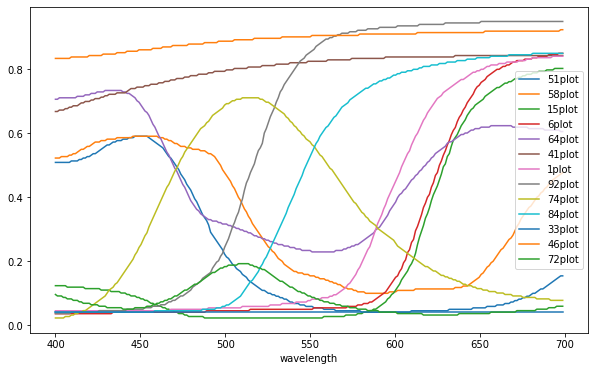

In [ ]:
reflectances.plot(kind="line", x="wavelength", figsize = (10,6))

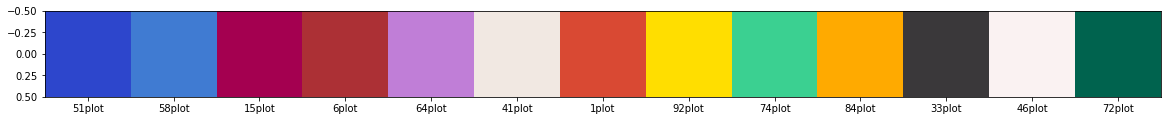

In [ ]:
plt.figure(figsize = (20,2))
plt.xticks(range(len(pigmentList)),np.squeeze(pigmentList))
plt.imshow([sRGBList.astype(int)])

## 3. Brightest and darkest pigments

In [ ]:
XYZ_pigment.iloc[XYZ_pigment["Y"].astype(float).idxmax(axis=0)]

pigment      46plot
X          0.871549
Y          0.902426
Z          0.966162
Name: 11, dtype: object

In [ ]:
XYZ_pigment.iloc[XYZ_pigment["Y"].astype(float).idxmin(axis=0)]

pigment       33plot
X          0.0390946
Y          0.0403587
Z          0.0452555
Name: 10, dtype: object